## Proyecto Individual: Comparación de Pérdidas Térmicas (Cilindro vs. Esfera)

Comparación de pérdidas térmicas (en estado estacionario y estado transiente) entre dos cuerpos de igual volumen (esfera y cilindro circular recto) para distintas condiciones de intercambio térmico con el ambiente. Se utiliza el Método de Líneas en coordenadas cilíndricas y esféricas para resolver la ecuación de conducción de calor 1D (radial) sujeta a convección en la superficie externa.

El objetivo de evaluar geometrías radica en que permite diseñar estanques más eficientes y económicos, aportando a una transición energética más sustentable en Chile.

In [155]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt

Primero, se definen los parámetros.

In [156]:
# Parámetros Físicos
k = 15.0          # Conductividad térmica [W/m·K]
rho = 7800.0      # Densidad [kg/m3]
cp = 500.0        # Calor específico [J/kg·K]
h = 10.0           # Coeficiente convectivo [W/m2·K]
T_inf = 293.0      # Temperatura del aire ambiente [K] (20 °C)
Ti = 373.0         # Temperatura inicial del estanque [K] (100 °C)

# Parámetros Geométrica (Mismo Volumen V) 
R_cilindro = 1.0  # Radio Externo del Cilindro [m]
L_cilindro = 2.0  # Longitud del Cilindro [m] (Asumo L=2R)

V_referencia = np.pi * R_cilindro**2 * L_cilindro

R_esfera = (3 * V_referencia / (4 * np.pi))**(1/3) # Radio equivalente (aprox. 1.145 m)

print(f"Radio del Cilindro (Ro): {R_cilindro} m") #Definido
print(f"Radio de la Esfera (mismo V): {R_esfera:.3f} m") #Calculado

Radio del Cilindro (Ro): 1.0 m
Radio de la Esfera (mismo V): 1.145 m


#### Parte 1.  Definición de Funciones (Método de Líneas)

Ambas funciones implementan el **Eje de Simetría** en $r=0$ (CB1) y el **Balance de Energía** en la superficie (CB2).

#### 1.1 Función para Cilindro

In [157]:
def dTdt_cilindro(t, T, k, rho, cp, h, T_inf, ro, N):
    
    ri = 0.0
    dr = (ro - ri) / (N - 1)
    r = np.linspace(ri, ro, N)
    alpha = k / (rho * cp)
    N_last = N - 1
    
    A = np.zeros((N, N))
    b = np.zeros(N)

    # Nodos interiores 
    for i in range(1, N - 1):
        r_i = r[i]

        A[i, i-1] = alpha * (1/dr**2 - 1/(2*r_i*dr)) 
        A[i, i]   = -2 * alpha / dr**2 
        A[i, i+1] = alpha * (1/dr**2 + 1/(2*r_i*dr)) 
        b[i] = 0
    
    # CB1 (i=0): Eje de Simetría 
    A[0, 0] = -4 * alpha / dr**2
    A[0, 1] = 4 * alpha / dr**2
    b[0] = 0

    # CB2 (i=N-1): Convección
    A[N_last, N_last - 1] = alpha / dr**2
    A[N_last, N_last] = -alpha / dr**2 - h / (rho * cp * dr)
    b[N_last] = h * T_inf / (rho * cp * dr)

    dT = A @ T + b

    return dT

#### 1.2 Función para Esfera

In [ ]:
def dTdt_esfera(t, T, k, rho, cp, h, T_inf, ro, N):
    
    ri = 0.0 # Eje de simetría
    dr = (ro - ri) / (N - 1)
    r = np.linspace(ri, ro, N)
    alpha = k / (rho * cp)
    N_last = N - 1
    
    A = np.zeros((N, N))
    b = np.zeros(N)


    # Nodos interiores
    for i in range(1, N - 1):
        r_i = r[i]
        
        A[i, i-1] = alpha * (1/dr**2 - 1/(r_i*dr)) 
        A[i, i]   = -2 * alpha / dr**2 
        A[i, i+1] = alpha * (1/dr**2 + 1/(r_i*dr)) 
        
        b[i] = 0 

    # CB1 (i=0): Eje de Simetría 
    A[0, 0] = -6 * alpha / dr**2
    A[0, 1] = 6 * alpha / dr**2
    b[0] = 0 
    

    # CB2 (i=N-1): Convección 
    
    A[N_last, N_last - 1] = alpha / dr**2
    A[N_last, N_last] = -alpha / dr**2 - h / (rho * cp * dr)
    b[N_last] = h * T_inf / (rho * cp * dr)

    dT = A @ T + b
    return dT

#### Parte 2. Ejecución del Método de Líneas (solve_ivp)

Se resuelve el sistema de EDOs para ambas geometrías asegurando que la Esfera tenga el mismo volumen que el Cilindro.

In [159]:
N = 100                    # Número de nodos
t_span = (0, 1000000)       # Tiempo total de simulación [s] 

T0 = np.ones(N) * Ti
t_eval = np.linspace(t_span[0], t_span[1], 100)
N_last = N - 1

# 1. Solución para el Cilindro
sol_cil = solve_ivp( dTdt_cilindro, t_span, T0, t_eval=t_eval, method='BDF', max_step=100, args=(k, rho, cp, h, T_inf, R_cilindro, N) )
T_surf_cil = sol_cil.y[N_last, :]

# 2. Solución para la Esfera
sol_esf = solve_ivp(dTdt_esfera, t_span, T0, t_eval=t_eval, method='BDF', max_step=100, args=(k, rho, cp, h, T_inf, R_esfera, N) )
T_surf_esf = sol_esf.y[N_last, :]

/opt/anaconda3/lib/python3.13/site-packages/numpy/_core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/var/folders/69/rm2zv55n0sd4487wvlr4jqs40000gn/T/ipykernel_39500/242810952.py:38: RuntimeWarning: invalid value encountered in matmul
  dT = A @ T + b
/opt/anaconda3/lib/python3.13/site-packages/scipy/integrate/_ivp/common.py:326: RuntimeWarning: invalid value encountered in subtract
  h = (y + factor * y_scale) - y
/opt/anaconda3/lib/python3.13/site-packages/scipy/integrate/_ivp/common.py:347: RuntimeWarning: invalid value encountered in subtract
  diff = f_new - f[:, None]


ValueError: array must not contain infs or NaNs

#### Parte 3. Análisis y Gráficos Comparativos

Se calcula la tasa de pérdida de calor instantánea ($Q$) en la superficie de cada cuerpo para comparar la eficiencia térmica.

$$\text{Pérdida de Calor Instantánea } (Q) = A_{\text{superficie}} \cdot h \cdot (T_{\text{superficie}} - T_{\infty})$$

In [ ]:
# Cálculo de Pérdidas Térmicas Instantáneas (Q_loss)

# 1. Cilindro: Área manto
A_cil= 2 * np.pi * R_cilindro * L_cilindro 
Q_loss_cil = A_cil * h * (T_surf_cil - T_inf)

# 2. Esfera: Área superficial 
A_esf = 4 * np.pi * R_esfera**2 
Q_loss_esf = A_esf * h * (T_surf_esf - T_inf)

print(f" Área Cilindro: {A_cil:.2f} m, Área Esfera: {A_esf:.2f} m")

 Área Cilindro: 12.57 m, Área Esfera: 16.47 m


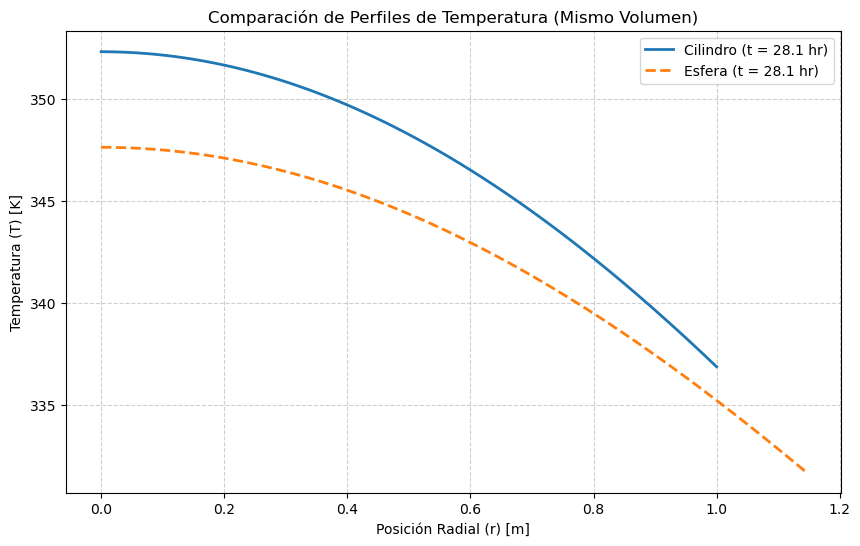

In [ ]:
# El vector radial para el cilindro y la esfera son diferentes debido a sus radios distintos.
r_grilla_cil = np.linspace(0, R_cilindro, N)
r_grilla_esf = np.linspace(0, R_esfera, N)

# --- Gráfico 1: Comparación del Perfil de Temperatura  ---
plt.figure(figsize=(10, 6))

# Seleccionamos un tiempo intermedio (e.g., t = 27.5 horas = 99000 s)
time_to_compare = 99000 # 27.5 horas
idx_compare = np.argmin(np.abs(sol_cil.t - time_to_compare))

# Perfiles de Temperatura en el tiempo seleccionado
T_profile_cil = sol_cil.y[:, idx_compare]
T_profile_esf = sol_esf.y[:, idx_compare]

plt.plot(r_grilla_cil, T_profile_cil, label=f'Cilindro (t = {sol_cil.t[idx_compare]/3600:.1f} hr)', linewidth=2)
plt.plot(r_grilla_esf, T_profile_esf, label=f'Esfera (t = {sol_esf.t[idx_compare]/3600:.1f} hr)', linewidth=2, linestyle='--')

plt.xlabel('Posición Radial (r) [m]')
plt.ylabel('Temperatura (T) [K]')
plt.title('Comparación de Perfiles de Temperatura (Mismo Volumen)')
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()
plt.show()

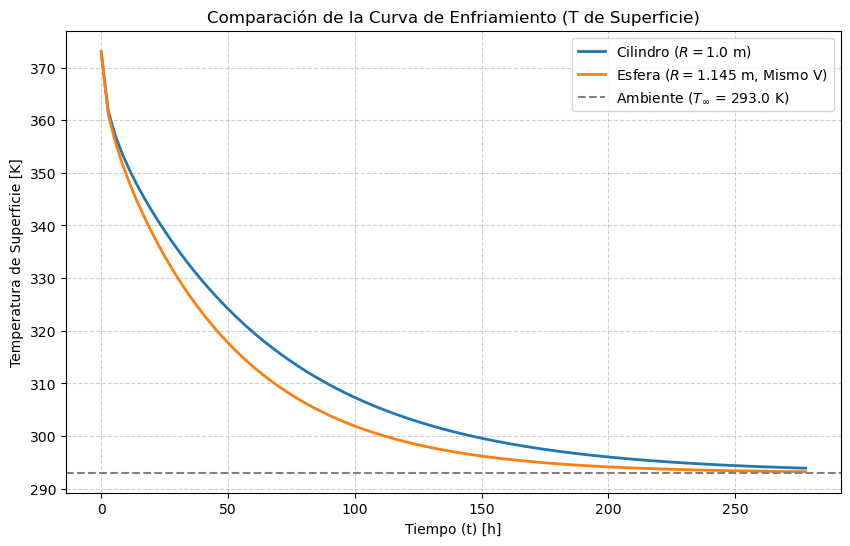

In [ ]:
# --- Gráfico 2: Comparación de la Curva de Enfriamiento (T_superficie vs. t) ---
plt.figure(figsize=(10, 6))
plt.plot(sol_cil.t/3600, T_surf_cil, label=f'Cilindro ($R={R_cilindro}$ m)', linewidth=2)
plt.plot(sol_esf.t/3600, T_surf_esf, label=f'Esfera ($R={R_esfera:.3f}$ m, Mismo V)', linewidth=2)

plt.axhline(T_inf, color='gray', linestyle='--', label=f'Ambiente ($T_{{\\infty}}$ = {T_inf} K)')

plt.xlabel('Tiempo (t) [h]')
plt.ylabel('Temperatura de Superficie [K]')
plt.title('Comparación de la Curva de Enfriamiento (T de Superficie)')
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()
plt.show()

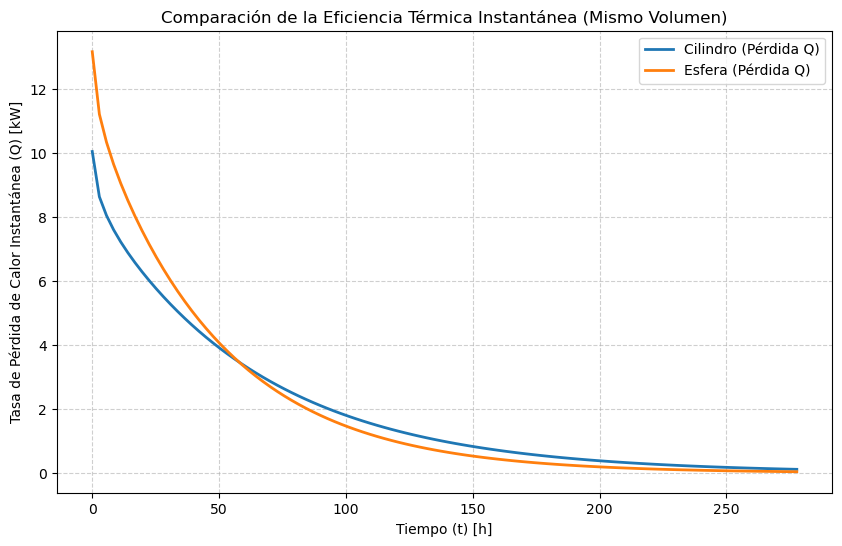

In [ ]:
# --- Gráfico 3: Comparación de la Tasa de Pérdida de Calor Instantánea (Q_loss vs. t) ---
plt.figure(figsize=(10, 6))
plt.plot(sol_cil.t/3600, Q_loss_cil/1000, label='Cilindro (Pérdida Q)', linewidth=2)
plt.plot(sol_esf.t/3600, Q_loss_esf/1000, label='Esfera (Pérdida Q)', linewidth=2)

plt.xlabel('Tiempo (t) [h]')
plt.ylabel('Tasa de Pérdida de Calor Instantánea (Q) [kW]')
plt.title('Comparación de la Eficiencia Térmica Instantánea (Mismo Volumen)')
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()
plt.show()